# scQUEST: Downsampling and Clustering

In this tutorial we show how to subsample and cluster the full 13million cell breast cancer dataset used in the basic scQUEST tutorial.

In [15]:
!pip install scanpy
!pip3 install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 758.4 kB/s eta 0:00:001m577.9 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.6 MB/s eta 0:00:002.7 MB/s eta 0:00:01


In [5]:
import scQUEST as scq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import anndata as ad
from sklearn.preprocessing import MinMaxScaler
import scanpy as sc

warnings.filterwarnings('ignore')

Load the full annData object (13,384,828 single-cell measurements of 68 channels). The patient id information is stored in `.obs[patient_number]`. 

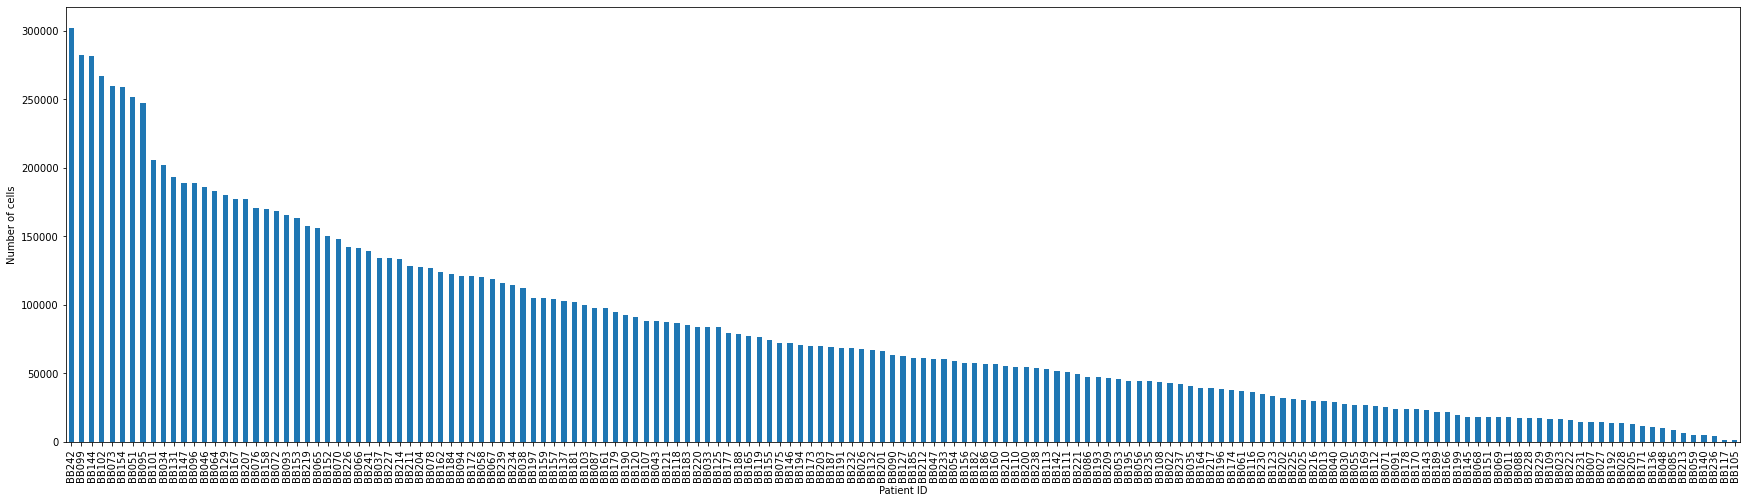

In [6]:
ad_raw = scq.dataset.breastCancerAtlasRaw()

plt.figure(figsize=(30, 8))
ad_raw.obs['patient_number'].value_counts().plot(kind='bar')
plt.xlabel('Patient ID')
plt.ylabel('Number of cells')
plt.show()

As you can already see, the number of cells per patient vastly differs, with few patients having more than 200,000 cells and some others less than 5,000. To minimize this discrepancies, one can either sample a fixed number of cells per patient:

In [7]:
ad_sub = ad_raw[ad_raw.obs.groupby('patient_number').sample(n=1000, random_state=1).index]

Or perform a custom approach similar to the one described in (Wagner et al., 2019), which is a bit more involved. Here, we sample varying fractions of cells based on the total number of cells in that sample. As you see in the barplot, this results to a more balanced distribution of cells per sample.

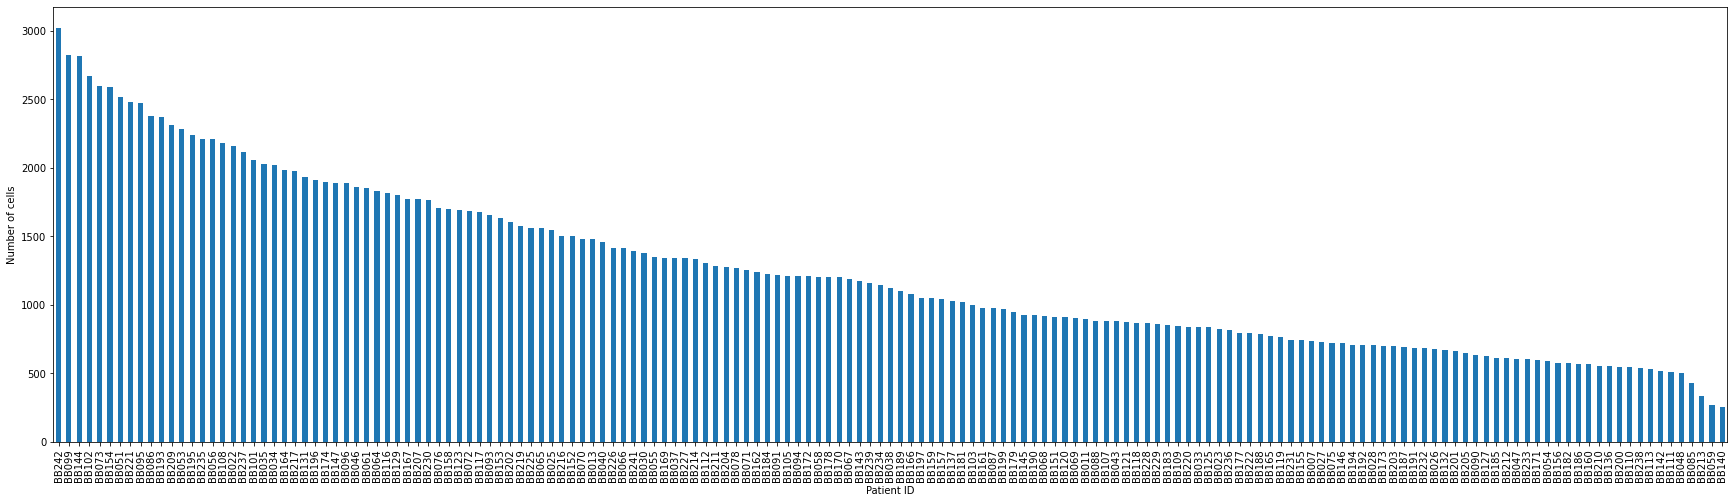

In [11]:
counts = ad_raw.obs['patient_number'].value_counts().to_dict()

# perform a custom downsampling
temp = []
for i,c in counts.items():
    if c < 2000:
        temp.append(ad_raw.obs[ad_raw.obs['patient_number']==i].index.values)
    elif c < 5000:
        temp.append(ad_raw.obs[ad_raw.obs['patient_number']==i].sample(frac=0.2).index.values)
    elif c < 50000:
        temp.append(ad_raw.obs[ad_raw.obs['patient_number']==i].sample(frac=0.05).index.values)
    elif c > 50000:
        temp.append(ad_raw.obs[ad_raw.obs['patient_number']==i].sample(frac=0.01).index.values)
    else:
        print('Error')
        
temp_array=np.concatenate(temp)
ad_sub_custom = ad_raw[temp_array]

plt.figure(figsize=(30, 8))
ad_sub_custom.obs['patient_number'].value_counts().plot(kind='bar')
plt.xlabel('Patient ID')
plt.ylabel('Number of cells')
plt.show()

Once we have a smaller dataset, we can cluster it to identify cell populations present. Here, we use [scanpy's](https://scanpy.readthedocs.io/en/stable/index.html) implementation of [Leiden clustering](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html). First, we'll select a number of relevant markers and then we'll preprocess the data, as before:

In [13]:
markers = ['139La_H3K27me3', '141Pr_K5', '142Nd_PTEN', '143Nd_CD44', '144Nd_K8K18','145Nd_CD31', '146Nd_FAP', 
           '147Sm_cMYC', '148Nd_SMA', '149Sm_CD24', '150Nd_CD68', '151Eu_HER2', '152Sm_AR', '153Eu_BCL2', 
           '154Sm_p53', '155Gd_EpCAM', '156Gd_CyclinB1', '158Gd_PRB', '159Tb_CD49f', '160Gd_Survivin', '161Dy_EZH2', 
           '162Dy_Vimentin', '163Dy_cMET', '164Dy_AKT', '165Ho_ERa', '166Er_CA9', '167Er_ECadherin', '168Er_Ki67', 
           '169Tm_EGFR', '170Er_K14', '171Yb_HLADR', '172Yb_clCASP3clPARP1', '173Yb_CD3', '174Yb_K7', 
           '175Lu_panK', '176Yb_CD45']

mask = []
for m in markers:
    mask.append(ad_sub_custom.var.desc.str.contains(m))
mask = pd.concat(mask, axis=1)
mask = mask.any(1)
ad_sub_custom.var['used_in_clf'] = mask
ad_sub_custom = ad_sub_custom[:, ad_sub_custom.var.used_in_clf]

# get raw data and arcsinh-transform using a cofactor of 5
X = ad_sub_custom.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
ad_sub_custom.layers['arcsinh'] = X

# min-max normalization
minMax = MinMaxScaler()
X = minMax.fit_transform(X)
ad_sub_custom.layers['arcsinh_norm'] = X

In [16]:
# compute neighbors and run leiden clustering algorithm
sc.pp.neighbors(ad_sub_custom, n_neighbors=30)
sc.tl.leiden(ad_sub_custom)
labels_clust=ad_sub_custom.obs['leiden'].astype(int)

Given such information, one can follow the same process as in (Wagner et al., 2019) (see Methods details, Epithelial cell selection and immune cell type selection) to annotate the clusters as epithelial, immune etc based on their marker expression.

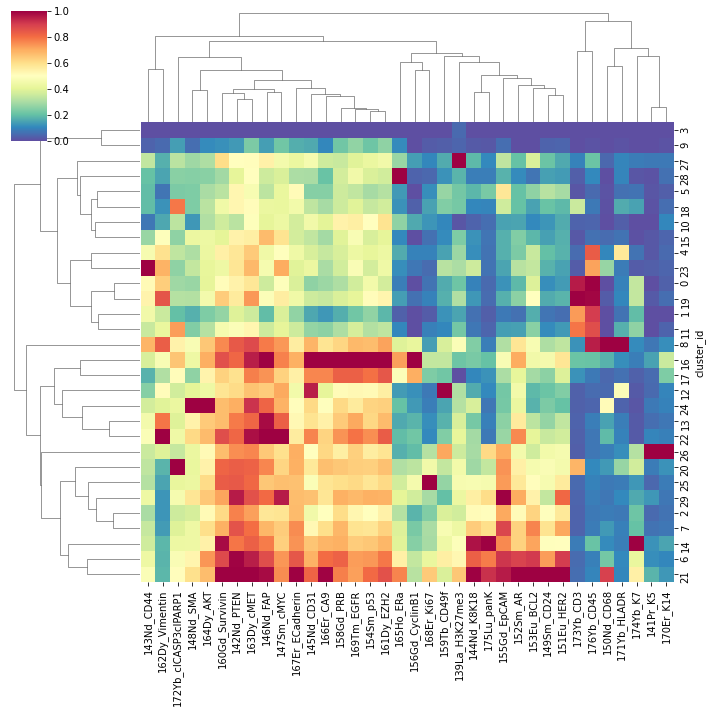

In [17]:
df = pd.DataFrame(data = ad_sub_custom.layers['arcsinh'], columns = markers, index = ad_sub_custom.obs.index)
df.insert(0, 'cluster_id', labels_clust)

ax = sns.clustermap(df.groupby('cluster_id').median(), metric='euclidean', standard_scale=1,  method='average', 
                    cmap="Spectral_r", figsize=(10, 10))